# Paddy Doctor: Paddy Disease Classification
  Identify the type of disease present in paddy leaf images

## Problem Statement
Rice (Oryza sativa) is one of the staple foods worldwide. Paddy, the raw grain before removal of husk, is cultivated in tropical climates, mainly in Asian countries. Paddy cultivation requires consistent supervision because several diseases and pests might affect the paddy crops, leading to up to 70% yield loss. Expert supervision is usually necessary to mitigate these diseases and prevent crop loss. With the limited availability of crop protection experts, manual disease diagnosis is tedious and expensive. Thus, it is increasingly important to automate the disease identification process by leveraging computer vision-based techniques that achieved promising results in various domains.


## Objective

The main objective of this competition is to develop a machine or deep learning-based model to classify the given paddy leaf images accurately. We provide a training dataset of 10,407 (75%) labeled images across ten classes (nine disease categories and normal leaf). Moreover, we also provide additional metadata for each image, such as the paddy variety and age. Your task is to classify each paddy image in the given test dataset of 3,469 (25%) images into one of the nine disease categories or a normal leaf.

### Data Source : <a href="https://www.kaggle.com/competitions/paddy-disease-classification">Kaggle</a>

## Install the required libraries

In [ ]:
!pip install opendatasets -q

## Import required libraries

In [ ]:
import os
import numpy as np
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import opendatasets as od
from keras.preprocessing.image import ImageDataGenerator

## Download the dataset

fe6eda3e2c96e167e5c40d393b4e42a2

In [ ]:
od.download('https://www.kaggle.com/competitions/paddy-disease-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omjiverma
Your Kaggle Key: ··········


100%|██████████| 1.02G/1.02G [00:44<00:00, 24.6MB/s]



Extracting archive ./paddy-disease-classification/paddy-disease-classification.zip to ./paddy-disease-classification


## Checking the downloded directory

In [ ]:
path='paddy-disease-classification'

In [ ]:
os.listdir(path)

['sample_submission.csv', 'train_images', 'test_images', 'train.csv']

In [ ]:
train_path=path+"/train_images"
test_path = path+'/test_images'

### Checking directories in train folder

---



In [ ]:
os.listdir(train_path),len(os.listdir(train_path))

(['hispa',
  'dead_heart',
  'bacterial_panicle_blight',
  'downy_mildew',
  'brown_spot',
  'tungro',
  'bacterial_leaf_blight',
  'blast',
  'normal',
  'bacterial_leaf_streak'],
 10)

So there are ten classes in which we have to classify data

## Images from dataset

In [ ]:
import glob
import random
from PIL import Image


In [ ]:
def show_grid(dir_path):
  imgs_paths = glob.glob(dir_path+'/*/*.jpg')
  rand_imgs = random.choices(imgs_paths, k=30)
  plt.figure(figsize=(20,20))
  for i, img in enumerate(rand_imgs, start=1):
    plt.subplot(5, 10, i)
    image = Image.open(img)
    image = image.resize((200,200))
    plt.imshow(image)



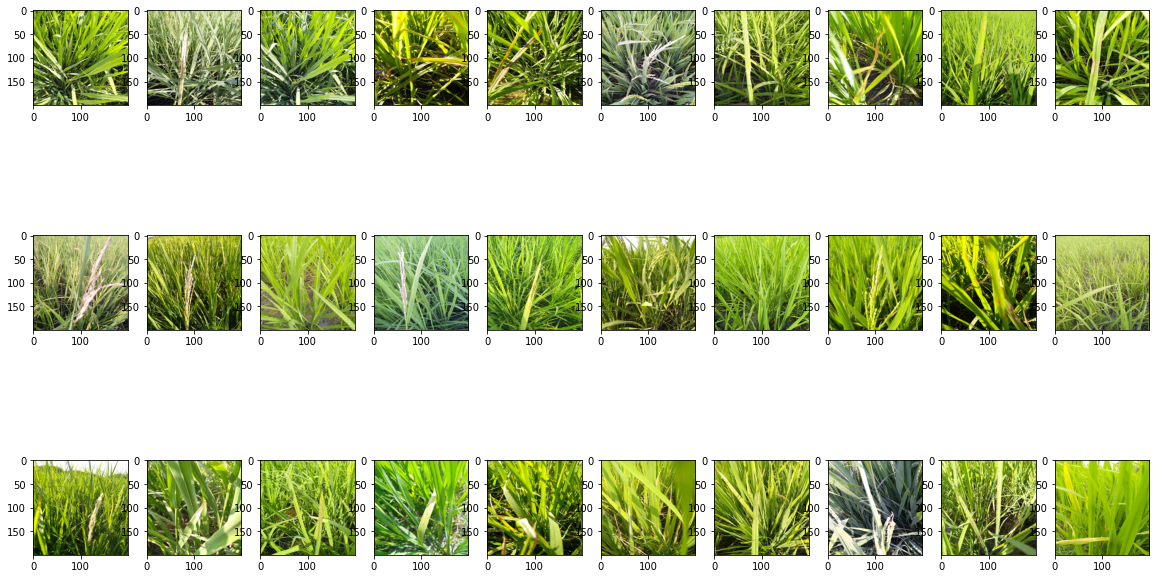

In [ ]:
show_grid(train_path)

## Data Presprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,
                                   zoom_range = 0.2,horizontal_flip = True,
                                   vertical_flip=True,validation_split=0.2)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    subset='training') # set as training data

validation_gen = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(150, 150),
    batch_size=32,
    subset='validation')

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [ ]:
labels = list(train_gen.class_indices.keys())

## Resnet50 Model

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import Model
import tensorflow as tf

In [ ]:
resnet50 = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,input_shape = (150,150,3))

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
model = Sequential()
model.add(resnet50)
model.add(Flatten())
model.output_shape
model.add(Dense(1000,activation = 'relu'))
model.add(Dense(10,activation = 'softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1000)              51201000  
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
Total params: 74,798,722
Trainable params: 74,745,602
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=1)):
  history = model.fit(train_gen,validation_data=validation_gen,epochs=7,workers=4)

Epoch 1/7
261/261 [==============================] - 103s 391ms/step - loss: 1.3487 - accuracy: 0.6024 - val_loss: 3.4794 - val_accuracy: 0.1059
Epoch 2/7
261/261 [==============================] - 100s 377ms/step - loss: 0.5649 - accuracy: 0.8206 - val_loss: 4.7273 - val_accuracy: 0.1704
Epoch 3/7
261/261 [==============================] - 100s 382ms/step - loss: 0.3672 - accuracy: 0.8906 - val_loss: 4.4670 - val_accuracy: 0.1960
Epoch 4/7
261/261 [==============================] - 99s 376ms/step - loss: 0.2560 - accuracy: 0.9190 - val_loss: 2.4632 - val_accuracy: 0.4781
Epoch 5/7
261/261 [==============================] - 100s 375ms/step - loss: 0.1910 - accuracy: 0.9399 - val_loss: 0.3611 - val_accuracy: 0.8946
Epoch 6/7
261/261 [==============================] - 98s 372ms/step - loss: 0.1560 - accuracy: 0.9539 - val_loss: 0.3054 - val_accuracy: 0.9153
Epoch 7/7
261/261 [==============================] - 98s 372ms/step - loss: 0.1436 - accuracy: 0.9576 - val_loss: 0.4271 - val_accur

In [ ]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=1)):
  history = model.fit(train_gen,validation_data=validation_gen,epochs=2,workers=4)

Epoch 1/2
261/261 [==============================] - 98s 369ms/step - loss: 0.1444 - accuracy: 0.9556 - val_loss: 0.2679 - val_accuracy: 0.9225
Epoch 2/2
261/261 [==============================] - 103s 390ms/step - loss: 0.1172 - accuracy: 0.9633 - val_loss: 0.2686 - val_accuracy: 0.9206


## Prediction for test data

In [ ]:
from keras.preprocessing import image

In [ ]:
submission ={'image_id':[],'label':[]}
for img in list(os.listdir(test_path)):
  test_img = image.load_img(test_path+'/'+img, target_size = (150, 150))
  img_arr = image.img_to_array(test_img)
  img_rescale = img_arr/255
  img_expand = np.expand_dims(img_rescale, axis = 0)
  pred_proba = model.predict(img_expand)
  result = labels[pred_proba.argmax()]
  submission['image_id'].append(img)
  submission['label'].append(result)


In [ ]:
import pandas as pd

In [ ]:
submission_df = pd.DataFrame(submission)
submission_df.to_csv('submission.csv',index=False)

#### Acheived accuracy of 0.90580 on test data